# Graph-based neural networks

# Set-up

In [5]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import Dataset, InMemoryDataset, DataLoader, Data
from torch_geometric.transforms import NormalizeFeatures, Compose, TargetIndegree
from tqdm import tqdm
import torch
import re
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
import os.path as osp
import os
from IPython import display
import time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# For debugging memory leaks:
import gc
# fix random generator seed (for reproducibility of results)
np.random.seed(42)
# matplotlib options
sns.set(color_codes=True)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 6)
#mpl.rcParams['agg.path.chunksize'] = 10000

In [6]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.'''
    
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(ave_grads)), ave_grads, alpha=1, lw=1, color="b")
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    print("avg grads {}".format(ave_grads))
    print("max grads {}".format(max_grads))
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim([-0.001, 1])
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow, zoomed")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [7]:
path = "./content/"

We now begin the loading and cleaning of the data.

# Load data

In [8]:
df = pd.read_excel(
     os.path.join(path+"DTU - data til case_LTMZones1.xlsx"),
     engine='openpyxl',
)


Converting dates to datetime format

In [9]:
df["Reservationstidspunkt"] = pd.to_datetime(df["Reservationstidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["Start tidspunkt"] = pd.to_datetime(df["Start tidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["Slut tidspunkt"] = pd.to_datetime(df["Slut tidspunkt"], format="%Y-%m-%d %H:%M:%S")
df["date"] = df["Start tidspunkt"].dt.date

Looking at the data below we see a number of data columns. We will only highlight the columns that are used. BilID is the unique ID for each car. We then have a start and end latitude/longitude, this is used to create the adjacency matrices of the graph, i.e. the matrix defining the edges between nodes of the graph. We have a start time and end time, this is the period where the car is in use and is defined by dates. Battery status might have an impact whether the car is being reserved or not, so it will be included. Finally, we will use the ZoneIDs indicating in which zone the car is located. The rest of the columns are assumed to not be of interest.

In [10]:
df.sort_values("Start tidspunkt").head(5)

,TurID,BilID,PersonID,Latitude (Start),Longitude (Start),Latitude (Slut),Longitude (Slut),Reservationstidspunkt,Start tidspunkt,Slut tidspunkt,Alder,Køn,Batteristatus (start),Batteristatus (slut),Km kørt,FromZoneID,ToZoneID,date
2,3,WBY1Z21070V307929,38610,55.6924,12.5831,55.7757,12.514,2017-07-31 07:28:38,2017-07-31 07:21:38,2017-08-01 12:49:44,21,M,0,0,19,102213,173051,2017-07-31
3,4,WBY1Z21040V307869,37425,55.6303,12.6489,55.7069,12.5871,2017-07-31 20:31:07,2017-07-31 20:31:07,2017-08-01 09:13:25,30,M,0,0,18,185203,102341,2017-07-31
4,5,WBY1Z21030V307877,24168,55.6936,12.5382,55.6775,12.4892,2017-07-31 20:48:30,2017-07-31 20:44:30,2017-08-01 08:52:43,28,M,0,0,5,102454,102771,2017-07-31
5,6,WBY1Z21090V308015,18497,55.7007,12.4734,55.6303,12.649,2017-07-31 21:11:52,2017-07-31 21:04:52,2017-08-01 04:28:55,42,M,0,0,28,102651,185203,2017-07-31
6,7,WBY1Z21070V308188,43226,55.68,12.5078,55.6925,12.505,2017-07-31 21:26:41,2017-07-31 21:25:41,2017-08-01 00:01:07,25,F,0,0,109,147234,102621,2017-07-31


Removing corrupt data, such as car IDs with "-". We don't remove ZoneIDs that are 0, we still have the latitude and longitude. We also do not remove km driven = 0, as trips might be $<1$ km, i.e. 100 meters, or perhaps the driver decided not to drive anyway, but still did a reservation. Battery status when zero is also removed as it makes no sense to have a battery status of 0 while driving several km's, and it is a rather limited amount of the data that are removed.

In [11]:
# Checking for NAs
print(df.isna().sum().sum())
# Removing all places where battery status = 0 for both start and end.
df=df[((df["Batteristatus (start)"]!=0)&(df["Batteristatus (slut)"]!= 0))]
# Removing invalid car ids:
df=df[(df["BilID"] != '-')]
#We noticed a few data points with a battery status of -1. This could perhaps mean two things: Broken battery or a small bug
# we assume it is a bug as the cars drive shortly after. We set these values to 0.
df.loc[df["Batteristatus (slut)"]<0,"Batteristatus (slut)"]=0

0


# Basic descriptive statistics

As seen we have quite a lot of data and around 280 days of tracking.

In [12]:
print("Total transactions:", len(df))
print("Total number of cars:", len(np.unique(df["BilID"])))
print("Number of unique customers:", len(np.unique(df["PersonID"])))
print("Period start:", df["date"].min())
print("Period end:", df["date"].max())

Total transactions: 362925
Total number of cars: 346
Number of unique customers: 25317
Period start: 2017-08-01
Period end: 2018-05-08


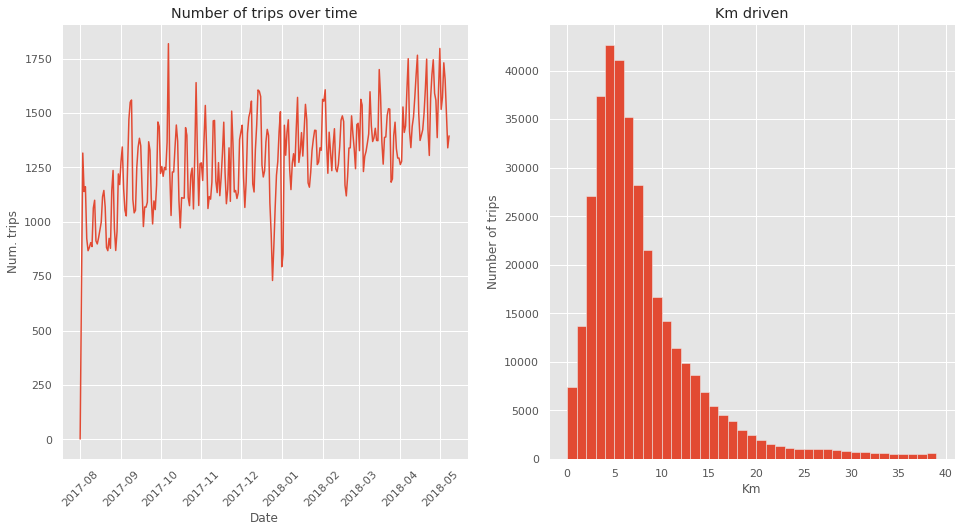

In [13]:
grouped = df.groupby("date")["TurID"].count()
fig, ax = plt.subplots(1,2, figsize=(2*8, 1*8))
ax[0].plot(grouped.index, grouped.values)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Num. trips")
ax[0].set_title("Number of trips over time")
ax[0].xaxis.set_tick_params(rotation=45)
ax[1].hist(df["Km kørt"], bins=range(40))
ax[1].set_title("Km driven")
ax[1].set_xlabel("Km")
ax[1].set_ylabel("Number of trips")
plt.show()


We see the customers mainly use DriveNow for smaller trips. We also see that the number of trips are increasing over time. Let us now look at number of trips for each zone. As some zones are very small there are almost no trips. Thus, we make zones bigger by dividing with 10.

In [14]:
# We make zones larger
df["FromZoneID"] = df["FromZoneID"] // 10
df["ToZoneID"] = df["ToZoneID"] // 10

Looking at the plot below we see that there are still zones with very few cars. We will turn the zones with almost no cars into larger zones. To reduce dimensions when modelling the data.

<AxesSubplot:xlabel='ToZoneID'>

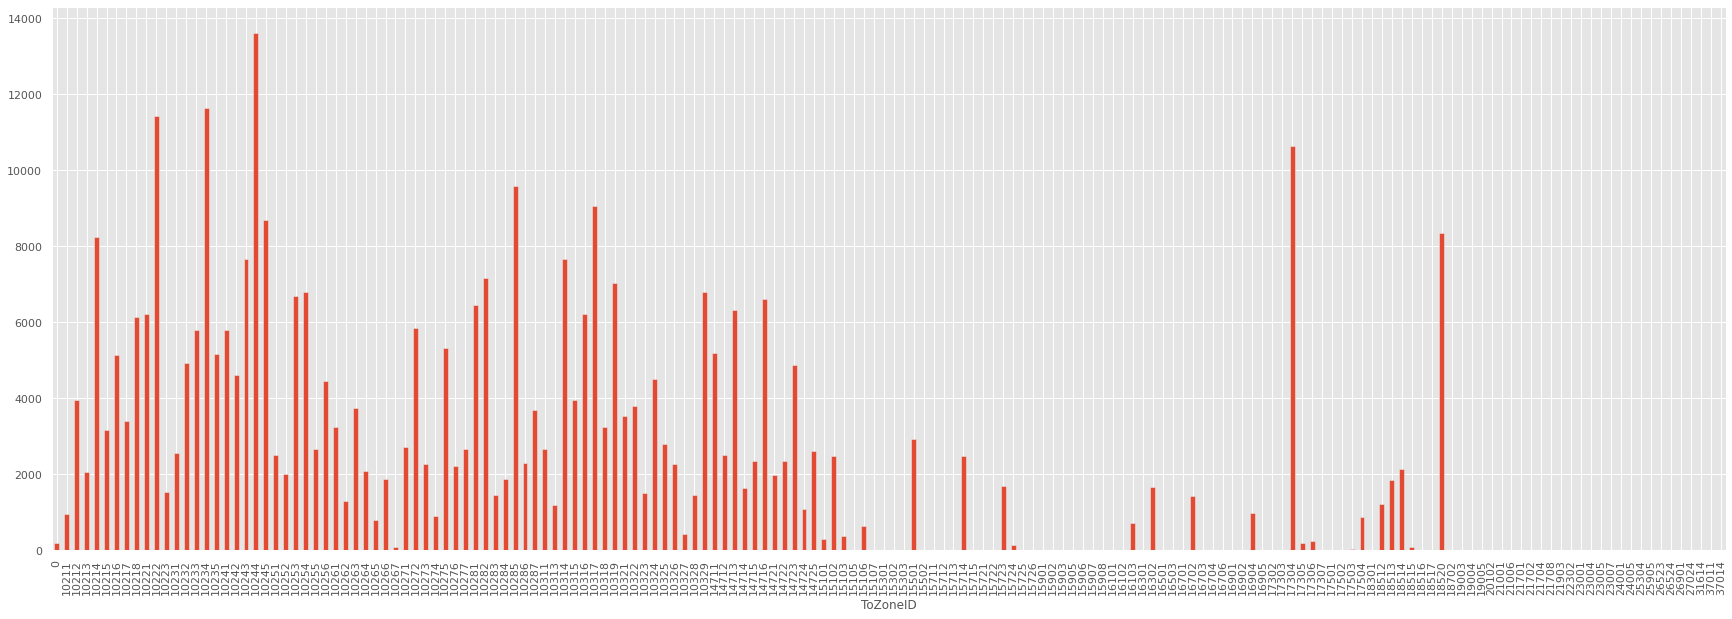

In [15]:
df.groupby(["ToZoneID"]).count()["BilID"].plot.bar(figsize=(30,10),stacked=True)

All zones starting from 15 and up to 37 will be expanded.

In [16]:
df_temp = df.copy()

In [17]:
df.loc[df_temp["FromZoneID"]>=15000,"FromZoneID"]=(df_temp.loc[df_temp["FromZoneID"]>=15000,"FromZoneID"]//10)
df.loc[df_temp["ToZoneID"]>=15000,"ToZoneID"]=(df_temp.loc[df_temp["ToZoneID"]>=15000,"ToZoneID"]//10)

We make the decision that trips assigned zones with less than 10 observations is simply zone 0, this can be a biased decision, but with so few observations the zones only add to the complexity of the problem without adding much information.

In [18]:
bool_zone = df.groupby(["ToZoneID"]).count()["BilID"]<10
zone_ids = (df.groupby(["ToZoneID"]).count()["BilID"]<10)[bool_zone].index.values

def fix_zone(x):
  if x in zone_ids:
    return 0
  else:
    return x

df["ToZoneID"]=df["ToZoneID"].apply(fix_zone)

bool_zone = df.groupby(["FromZoneID"]).count()["BilID"]<10
zone_ids = (df.groupby(["FromZoneID"]).count()["BilID"]<10)[bool_zone].index.values
df["FromZoneID"]=df["FromZoneID"].apply(fix_zone)

<AxesSubplot:xlabel='ToZoneID'>

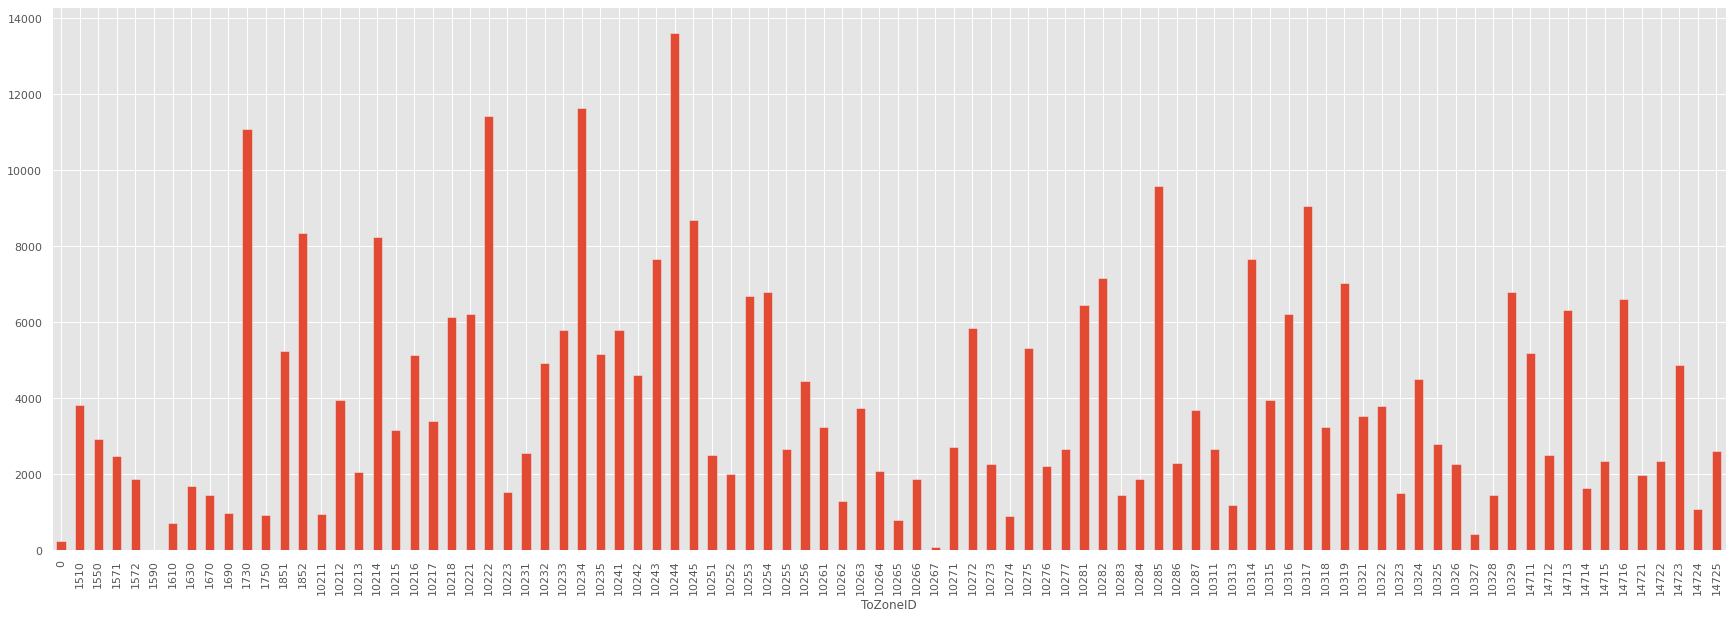

In [19]:
df.groupby(["ToZoneID"]).count()["BilID"].plot.bar(figsize=(30,10),stacked=True)

The zones are looking better now and we will proceed with the data cleaning.

# Process data and generate additional features
In this section we add additional features to the data and process the data to make it eligible for graph-based modelling.

### Generate average demand and supply for each zone (Credits: Filipe and Bojan, DTU management)
We can find demand and supply by looking at the car fleet. Demand can be seen as the number of customers requesting a car at a specific time. Meanwhile the supply can be seen as the number of cars available.

In [20]:
#Get all zone ids and vehicle ids
zone_ids = np.unique((df["FromZoneID"] ).astype(np.int)).tolist()
for z_id in np.unique((df["ToZoneID"]  ).astype(np.int)).tolist():
    if z_id not in zone_ids:
        zone_ids.append(z_id)
vehicle_ids = np.unique(df["BilID"])

In [21]:
# sort trips by start time
df_sorted = df.sort_values("Start tidspunkt")

n = 0
start_date = datetime(2017, 8, 5) # ignore data before this datetime
current_time = 0
current_date = start_date.strftime("%Y-%m-%d %H:00")
dates_demand = {}
demand = {}
demand_temp = {z_id:0 for z_id in zone_ids}
for ix, row in df_sorted.iterrows():
    n += 1
    if not n % 100000:
        print("%d of %d rows processed for far..." % (n, len(df)))
    
    # ignore invalid rows
    if row["BilID"] == '-':
        continue
    try:
        start_lat = float(row["Latitude (Start)"])
        start_lng = float(row["Longitude (Start)"])
        end_lat = float(row["Latitude (Slut)"])
        end_lng = float(row["Longitude (Slut)"])
    except:
        continue
    
    # skip the first days so that we can figure out the positions of all cars
    if row["Start tidspunkt"] < start_date:
        continue
    
    # get current time bin (by hour)
    time = int((row["Start tidspunkt"] - start_date).total_seconds() / 60 / 60)
    
    if time != current_time: # if time bin (hour) has changed
        
        # save demand (note that this is the demand for the current time bin)
        dates_demand[current_time] = current_date
        demand[current_time] = demand_temp
        
        # reset variables
        demand_temp = {z_id:0 for z_id in zone_ids}
        current_time = time
        current_date = row["Start tidspunkt"].strftime("%Y-%m-%d %H:00")
        
    # get origin and destination zones
    origin_zone = int(int(row["FromZoneID"]))
    destination_zone = int(int(row["ToZoneID"]))
    
    # update demand for corresponding zone
    demand_temp[origin_zone] += 1

print("Done!")

100000 of 362925 rows processed for far...
200000 of 362925 rows processed for far...
300000 of 362925 rows processed for far...
Done!


In [22]:
# sort trips by end time
df_sorted = df.sort_values("Slut tidspunkt")
# keep track of all vehicles at every time step
vehicle_pos = {v_id:None for v_id in vehicle_ids}
vehicle_zone = {v_id:None for v_id in vehicle_ids}
n = 0
start_date = datetime(2017, 8, 5) # ignore data before this datetime
current_time = 0
current_date = start_date.strftime("%Y-%m-%d %H:00")
dates_supply = {}
supply = {}
for ix, row in df_sorted.iterrows():
    n += 1
    if not n % 100000:
        print("%d of %d rows processed for far..." % (n, len(df)))
    
    # ignore invalid rows
    if row["BilID"] == '-':
        continue
    try:
        start_lat = float(row["Latitude (Start)"])
        start_lng = float(row["Longitude (Start)"])
        end_lat = float(row["Latitude (Slut)"])
        end_lng = float(row["Longitude (Slut)"])
    except:
        continue
    
    # skip the first days so that we can figure out the positions of all cars
    if row["Start tidspunkt"] < start_date:
        # save vehicle position for tracking
        vehicle_pos[row["BilID"]] = (end_lat, end_lng)
        continue
    
    # get current time bin (by hour)
    time = int((row["Slut tidspunkt"] - start_date).total_seconds() / 60 / 60)
    
    if time != current_time: # if time bin (hour) has changed
        # compute supply
        supply_temp = {z_id:0 for z_id in zone_ids}
        for v_id in vehicle_zone:
            if vehicle_zone[v_id] != None:
              supply_temp[vehicle_zone[v_id]] += 1
        
        # save supply (note that this will be supply for the next bin!)
        dates_supply[current_time+1] = row["Slut tidspunkt"].strftime("%Y-%m-%d %H:00")
        supply[current_time+1] = supply_temp
        
        # reset variables
        current_time = time
        current_date = row["Slut tidspunkt"].strftime("%Y-%m-%d %H:00")
        
    # get origin and destination zones
    origin_zone = int(int(row["FromZoneID"]) )
    destination_zone = int(int(row["ToZoneID"]) )
    
    # update vehicle position and zone in tracking
    vehicle_pos[row["BilID"]] = (end_lat, end_lng)
    vehicle_zone[row["BilID"]] = destination_zone

print("Done!")

100000 of 362925 rows processed for far...
200000 of 362925 rows processed for far...
300000 of 362925 rows processed for far...
Done!


Calculate the average demand and supply of each zone.

In [23]:
avg_demand = {}
for z_id in zone_ids:
    demand_ts = [demand[t][z_id] for t in demand if t in supply.keys()]
    mean_demand = np.mean(demand_ts)
    avg_demand[str(z_id)] = mean_demand
    if mean_demand < 1:
        continue
    #print("Zone: %d -> Avg. demand: %.1f" % (z_id, mean_demand))
  

In [24]:
avg_supply = {}
for z_id in zone_ids:
    supply_ts = [supply[t][z_id] for t in supply if t in supply.keys()]
    mean_supply = np.mean(supply_ts)
    avg_supply[str(z_id)] = mean_supply
    if mean_supply < 3:
        continue
    #print("Zone: %d -> Avg. supply: %.1f" % (z_id, mean_supply))

Visualising an extreme case.

Fraction of boundary cases: 0.037
Fraction of problematic cases: 0.010


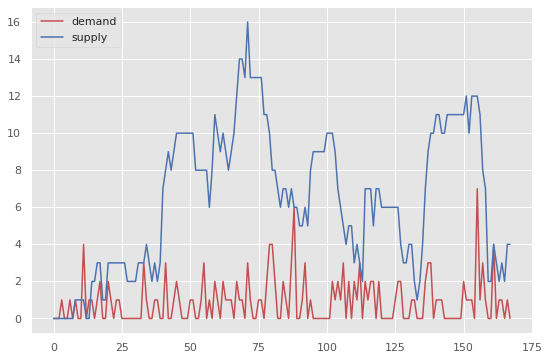

In [25]:
#Let's see an extreme case:
zone_id = 10243
demand_ts = [demand[t][zone_id] for t in demand if t in supply.keys()]
supply_ts = [supply[t][zone_id] for t in demand if t in supply.keys()]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

We see the demand is a lot lower than the supply. This can be a problem as if there is too high a supply relative to demand, then the cars might be waiting a long time to be picked up.

In [26]:
# check fraction of cases in which demand is greater than (or equal to) the supply
total_cases = 0
boundary_cases = 0
problem_cases = 0
missings = 0
for t in demand:
    for z_id in zone_ids:
        if t not in supply.keys():
            missings += 1
            continue
        if demand[t][z_id] == supply[t][z_id]:
            boundary_cases += 1
        elif demand[t][z_id] > supply[t][z_id]:
            problem_cases += 1
        total_cases += 1

print("Total cases:", total_cases)
print("Total missings:", missings)
print("Total boundary cases: %d (%.1f perc.)" % (boundary_cases, 100.0*boundary_cases/total_cases))
print("Total problematic cases: %d (%.1f perc.)" % (problem_cases, 100.0*problem_cases/total_cases))

Total cases: 596250
Total missings: 900
Total boundary cases: 97140 (16.3 perc.)
Total problematic cases: 9829 (1.6 perc.)


We add demand and supply to our dataframe as it might assist the model modelling the problem.

In [27]:
# Adding demand to dataframe
temp = pd.DataFrame.from_dict(avg_demand, orient='index').reset_index()
temp.columns = ["ToZoneID", "demand"]
temp.ToZoneID = pd.to_numeric(temp.ToZoneID)
df= pd.merge(df, temp, left_on=['ToZoneID'], right_on=['ToZoneID'])

In [28]:
# Adding supply to dataframe
temp = pd.DataFrame.from_dict(avg_supply, orient='index').reset_index()
temp.columns = ["ToZoneID", "supply"]
temp.ToZoneID = pd.to_numeric(temp.ToZoneID)
df= pd.merge(df, temp, left_on=['ToZoneID'], right_on=['ToZoneID'])

### Adding hours, week days and season

We are not modelling the temporal distribution, instead we add the hours and minutes, weekday, and the season, to see how they relate to the time until the car is picked up.

In [29]:
# Adding hour
df["hour_drop_off"]=df["Slut tidspunkt"].dt.hour
# Adding minutes
df["minute_drop_off"]=df["Slut tidspunkt"].dt.minute
# Adding weekday
df["day_drop_off"]=df["Slut tidspunkt"].dt.weekday
# Adding season
def get_season(month):
  season_list = [("winter",(12, 12)),
                 ("spring",(3, 5)),
                 ("summer",(6, 8)),
                 ("autumn",(9, 11)),
                 ("winter",(1, 2)),
                 ]
  for season, (start, end) in season_list:
    if start <= month <= end:
      return season

  print("No season was found")
  return None
  
df["season"]=[get_season(month) for month in df["Slut tidspunkt"].dt.month]
    



### Adding target variables - Time until pickup

We now add the target value, time until pickup. It is simply calculated by the difference between the end time of a car trip and the start time of the cars' next trip.

In [30]:
# Sorting values to calculate waiting times.
df = df.sort_values(["BilID","Slut tidspunkt"])
# First we find all waiting times until pickup
waiting_time = df["Start tidspunkt"]-df.groupby("BilID")["Slut tidspunkt"].shift()
# Remove NAs, reset indices to match
waiting_time = waiting_time[waiting_time.isna() == False].reset_index(drop=True)
# Removing last elements of each group. We do not know the waiting time until picked up for the last trip
df_processed = df.copy()
df_processed = df_processed.groupby("BilID", group_keys=False).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
# Storing
df_processed["time_until_pickup"] = waiting_time

We now debug to check if any mishaps occured. We see we get a negative difference in time. This is not good, so we check the data and see that times are overlapping, 2017-10-04 20:56:46 to 2017-10-04 21:25:23 is contained within 2017-10-04 09:52:33 and 2017-10-05 03:01:23, but they are listed as two trips. This makes no sense, maybe a bug in the tracking.

In [31]:
print(df_processed.time_until_pickup.min())
id_min = df_processed.time_until_pickup.idxmin()
df_processed[(id_min-1):(id_min+2)]

-1 days +12:27:10


,TurID,BilID,PersonID,Latitude (Start),Longitude (Start),Latitude (Slut),Longitude (Slut),Reservationstidspunkt,Start tidspunkt,Slut tidspunkt,...,FromZoneID,ToZoneID,date,demand,supply,hour_drop_off,minute_drop_off,day_drop_off,season,time_until_pickup
192713,74329,WBY1Z21050V308092,40350,55.7839,12.5204,55.6948,12.5522,2017-10-04 14:54:58,2017-10-04 14:50:58,2017-10-04 15:09:11,...,1730,10244,2017-10-04,2.066717,9.035865,15,9,2,autumn,0 days 05:47:35
192714,74957,WBY1Z21050V308092,36179,55.6948,12.5522,55.6597,12.6044,2017-10-04 21:08:46,2017-10-04 20:56:46,2017-10-04 21:25:23,...,10244,10317,2017-10-04,1.389434,7.231465,21,25,2,autumn,-1 days +12:27:10
192715,74106,WBY1Z21050V308092,9485,55.6872,12.5303,55.7054,12.554,2017-10-04 10:57:33,2017-10-04 09:52:33,2017-10-05 03:01:23,...,14716,10243,2017-10-04,1.168906,6.447408,3,1,3,autumn,0 days 05:55:09


We also check if there are times where end time is an earlier date than start time, which doesn't make any sense either.

In [32]:
((df_processed["Slut tidspunkt"]-df_processed["Start tidspunkt"]).dt.total_seconds() < 0).sum()

1

We check how many times the bugs occur and save their trip indices

In [33]:
count = 0
get_bad_value_id = []

for idx, x in df_processed.iterrows():
  if x.time_until_pickup.total_seconds() < 0.0:
    get_bad_value_id.append(df_processed.TurID[idx+1])
    count += 1
  if ((x["Slut tidspunkt"]-x["Start tidspunkt"]).total_seconds() < 0):
    get_bad_value_id.append(df_processed.TurID[idx])
    count += 1
print(count)

11


Now removing bad values

In [34]:
df=df.loc[~df.TurID.isin(get_bad_value_id)]
# Redoing without bad values.
waiting_time = df["Start tidspunkt"]-df.groupby("BilID")["Slut tidspunkt"].shift()
waiting_time = waiting_time[waiting_time.isna() == False].reset_index(drop=True)
df_processed = df.groupby("BilID", group_keys=False).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
df_processed["time_until_pickup"] = waiting_time

In [35]:
end_park=df.groupby("BilID")["Start tidspunkt"].shift(-1)
end_park=end_park[end_park.isna()==False].reset_index(drop=True)
df_processed["Start tidspunkt"] = end_park

Redefining the columns to make them more readible and easier to work with.

In [36]:
# Removing some of the data we do not need anymore
df_processed.drop(labels=["TurID","PersonID","Latitude (Start)","Longitude (Start)", "Reservationstidspunkt", "Alder", "Km kørt", "Køn", "date", "FromZoneID"], axis=1, inplace=True)

#redefining variables
df_processed.columns = ['carid', 'latitude', 'longitude', "end_parking", "start_parking", 'battery_status_start', 'battery_status_end', 'zoneid','avg_demand', 'avg_supply', 'hour',"minute",'day','season', 'time_until_pickup' ]

The features are now focused on when the car is parked. This means `latitude`, `longitude` are the location where the car is parked after use. `battery_status` is the battery status for when the car is parked, we removed battery status when the car is picked up (`Batteristatus (start)`) as it contains the same information as (`Batteristatus (slut)`), i.e. if the car is parked with a low battery and the average customer does not prefer a low battery, we would reckon that there is a longer time before the car is picked up again and vice versa. In which zone the parked car is located, `zoneid`. We do not find reservation time point very important for the analysis, neither the start times and end times of the trip. These are solely used to calculate the time before picked up. Age, sex, person id, and trip id are also all irrelevant. We added the hour the car was parked, the day, and the season, they all might tell something about when there is a high demand for the parked cars. Finally, we added the target variable `time_until_pickup`, which shows how long time before the specific car is picked up by a customer.  

# Finding an average charging rate of the batteries

As the battery status changes over time we want to find the average charging rate of the batteries. First we check how many of the batteries are actually charging.

In [37]:
charging = (df_processed["battery_status_start"].shift(-1) - df_processed["battery_status_end"] > 0 )
(charging).sum() / len(df_processed)

0.1750292358950597

Around 17%, this is not that many, as such we probably need an indicator whether the battery is charging or not if we want it to be dynamically included to the graph.

In [38]:
df_processed["battery_charging"] = (charging)*1

In [39]:
# we see the indicator now indicates the battery is charging, e.g. from 14 to 100.
df_processed[39:41]

,carid,latitude,longitude,end_parking,start_parking,battery_status_start,battery_status_end,zoneid,avg_demand,avg_supply,hour,minute,day,season,time_until_pickup,battery_charging
39,WBY1Z21000V307738,55.6685,12.5541,2017-08-11 09:54:57,2017-08-10 21:40:56,19,14,10281,1.023698,3.33469,21,40,3,summer,0 days 12:14:01,1
40,WBY1Z21000V307738,55.6687,12.5543,2017-08-11 19:03:57,2017-08-11 12:08:21,100,91,10281,1.023698,3.33469,12,8,4,summer,0 days 06:55:36,0


We now find the average charging rate

In [40]:
interval = 60*60 # 1 hour

amount_charged = (df_processed["battery_status_start"].shift(-1) - df_processed["battery_status_end"])[charging]
time_charging_seconds = df_processed["time_until_pickup"][charging].dt.total_seconds()
avg_percent_charge = ( amount_charged / time_charging_seconds ).mean() * interval
print(avg_percent_charge)

10.601436334770751


As such we charge around 10% per hour. So to fully charge a car from 0 to 100 percent takes around 10 hours. This calculation assumes a linear charging rate. Modern batteries are often not following a linear charging routine, to give an example; it might not follow a linear increase in time to charge from 0 to 90 versus 0 to 100, the last 10 percent is often slower. We do not take this into account due to not enough information.

In [41]:
df_processed.drop(["battery_status_start"], axis=1, inplace=True)

### Visualising the data and Encoding features

We now have the following data frame.

In [42]:
'''
carid: ID of car
latitude: latitude of car parked after ended trip
longitude: longitude of car parked after ended trip
end_parking: date parking ended
start_parking: date parking started
battery_status_end: Status of battery when trip ended or when car got parked.
zoneid: The zone where car is parked after ended trip
demand: avg zone demand
supply: avg zone supply
hour: hour of the day when car is parked
minute: minute of the day when car is parked
day: day when car is parked
season: season when car is parked
time_until_pickup: the time it took until next trip is initialised
battery_charging: whether the battery charges or not.
'''
df_processed.head(5)

,carid,latitude,longitude,end_parking,start_parking,battery_status_end,zoneid,avg_demand,avg_supply,hour,minute,day,season,time_until_pickup,battery_charging
0,WBY1Z21000V307738,55.659,12.6055,2017-08-04 14:34:20,2017-08-04 13:48:55,30,10317,1.389434,7.231465,13,48,4,summer,0 days 00:45:25,0
1,WBY1Z21000V307738,55.6744,12.6029,2017-08-04 14:57:41,2017-08-04 14:48:43,27,10314,1.174642,4.716998,14,48,4,summer,0 days 00:08:58,0
2,WBY1Z21000V307738,55.6199,12.581,2017-08-04 15:30:26,2017-08-04 15:21:20,22,10329,0.985660,5.783002,15,21,4,summer,0 days 00:09:06,0
3,WBY1Z21000V307738,55.6444,12.6153,2017-08-04 16:06:01,2017-08-04 15:42:20,18,10325,0.441660,3.867993,15,42,4,summer,0 days 00:23:41,0
4,WBY1Z21000V307738,55.6455,12.6365,2017-08-04 19:33:27,2017-08-04 16:15:30,17,10321,0.536453,4.056811,16,15,4,summer,0 days 03:17:57,0


Before encoding let us visualise some relevant data.

In [43]:
df_temp = df_processed.copy()
df_temp["time_until_pickup"] = df_temp["time_until_pickup"].dt.total_seconds()//(60)


We divide pickup times into categories, short, decent, long, and very long pickup time.

In [44]:
df_temp["pickup_time_cat"]=pd.cut(df_temp.time_until_pickup,bins=[-1,30,60*2,60*8,80000],labels=['short','decent','long','very long'])

Let us see how the different categories vary depending on the time of day. Looking at the figure below we see that there is a rise in initial parking time from 17:00 to around 00:00. Intuitively, this makes sense, as it is at this point most people arrive at home and park the car until it will get picked up next morning around 8:00-9:00.

<AxesSubplot:xlabel='hour'>

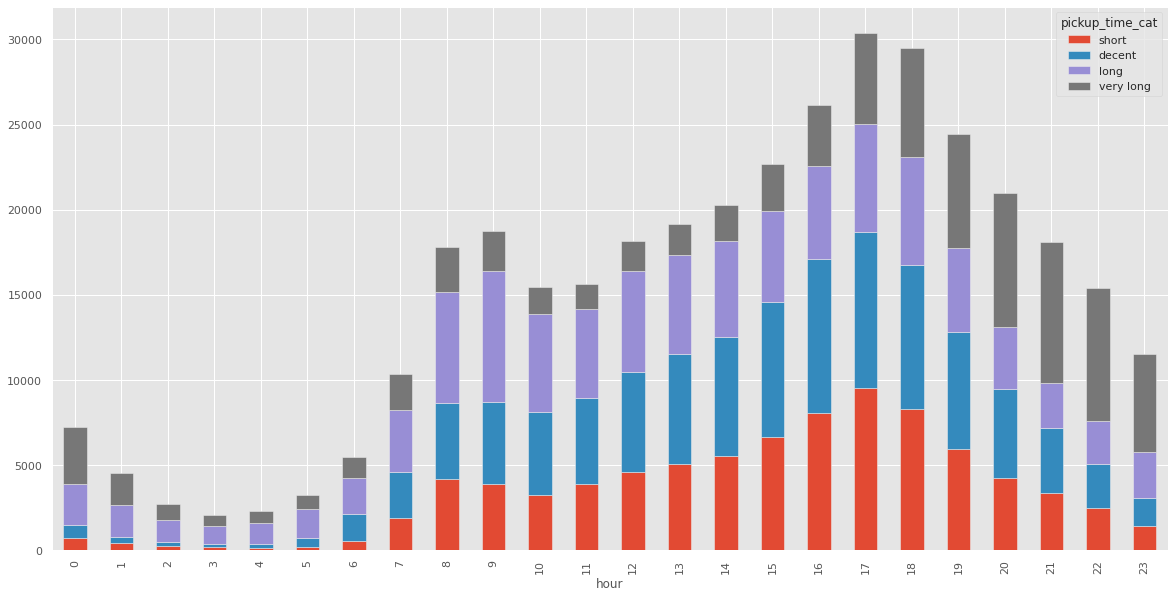

In [45]:
df_temp.groupby(["hour", "pickup_time_cat"]).count()["carid"].unstack(-1).plot.bar(figsize=(20,10),stacked=True)

Looking at the seasons we see the data is fairly unbalanced, we cut away most of the summer. Besides that not much difference is observed between the seasons, except that colder months seem to have a rise in pickups.

<AxesSubplot:xlabel='season'>

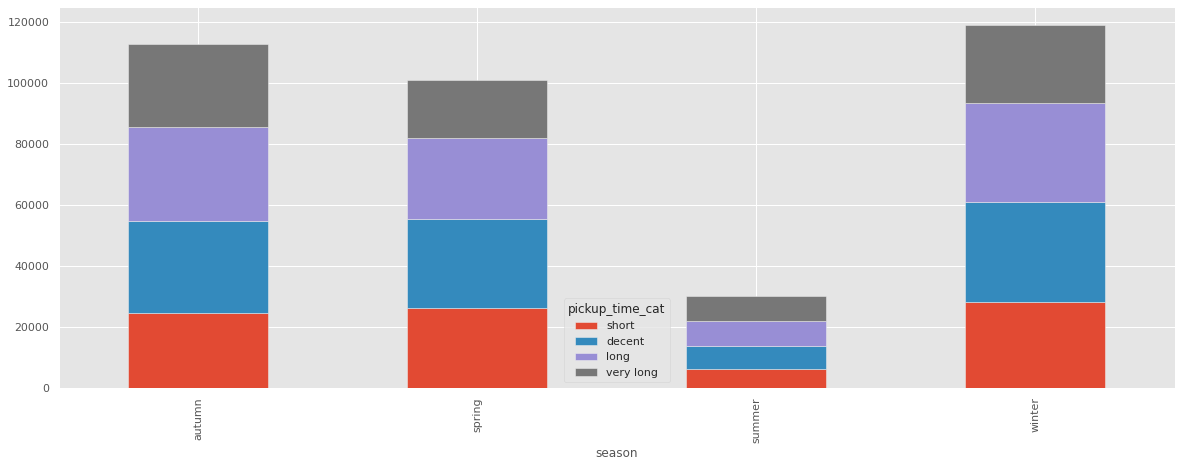

In [46]:
df_temp.groupby(["season", "pickup_time_cat"]).count()["carid"].unstack(-1).plot.bar(figsize=(20,7),stacked=True)

Looking at the battery status there seem to be a slight trend when the car is parked. Cars parked with low battery time seem to have a higher waiting time before picked up again by a customer.

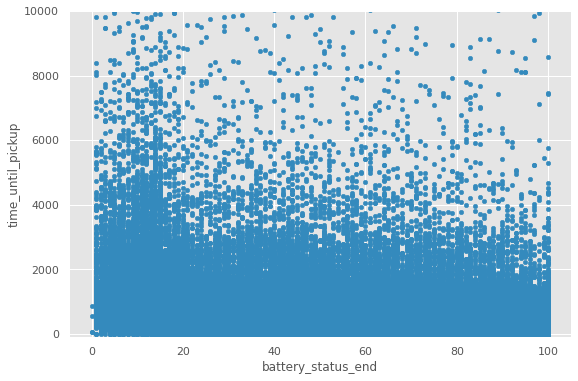

In [47]:
df_temp.plot.scatter(x='battery_status_end',y='time_until_pickup', ylim=[-100,10000]);

Just to show the target variables, we see they are highly skewed. Short pickup times are dominating.

<AxesSubplot:ylabel='Frequency'>

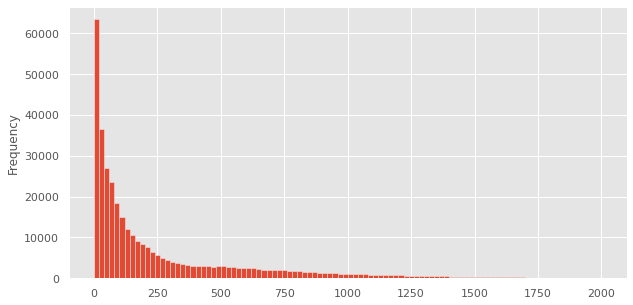

In [48]:
df_temp["time_until_pickup"].plot.hist(figsize=(10,5), bins=100, range=(0,2000))

Before encoding let us check the correlation between the features.

In [49]:
df_temp["season"]=pd.Categorical(df_temp["season"]).codes
df_temp.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,zoneid,avg_demand,avg_supply,hour,minute,day,season,time_until_pickup,battery_charging
zoneid,1.00,-0.08,-0.53,0.12,-0.01,0.04,0.01,-0.15,-0.06
avg_demand,-0.08,1.00,0.65,0.00,-0.00,-0.01,0.01,-0.09,0.07
avg_supply,-0.53,0.65,1.00,-0.07,0.00,-0.04,0.00,0.08,0.08
hour,0.12,0.00,-0.07,1.00,-0.03,-0.02,-0.01,0.02,0.03
minute,-0.01,-0.00,0.00,-0.03,1.00,-0.01,0.00,0.00,-0.00
day,0.04,-0.01,-0.04,-0.02,-0.01,1.00,-0.01,-0.01,0.00
season,0.01,0.01,0.00,-0.01,0.00,-0.01,1.00,-0.00,0.04
time_until_pickup,-0.15,-0.09,0.08,0.02,0.00,-0.01,-0.00,1.00,0.27
battery_charging,-0.06,0.07,0.08,0.03,-0.00,0.00,0.04,0.27,1.00


In [50]:
df_temp.corr(method="spearman").style.background_gradient(cmap='coolwarm').set_precision(2)

,zoneid,avg_demand,avg_supply,hour,minute,day,season,time_until_pickup,battery_charging
zoneid,1.00,-0.16,-0.24,0.10,-0.01,0.03,-0.00,-0.04,-0.05
avg_demand,-0.16,1.00,0.77,0.00,-0.00,-0.01,0.01,-0.12,0.07
avg_supply,-0.24,0.77,1.00,-0.03,-0.00,-0.02,0.01,0.05,0.07
hour,0.10,0.00,-0.03,1.00,-0.04,-0.01,-0.01,0.03,0.04
minute,-0.01,-0.00,-0.00,-0.04,1.00,-0.01,0.00,0.00,-0.00
day,0.03,-0.01,-0.02,-0.01,-0.01,1.00,-0.01,-0.04,0.01
season,-0.00,0.01,0.01,-0.01,0.00,-0.01,1.00,-0.02,0.04
time_until_pickup,-0.04,-0.12,0.05,0.03,0.00,-0.04,-0.02,1.00,0.37
battery_charging,-0.05,0.07,0.07,0.04,-0.00,0.01,0.04,0.37,1.00


In [46]:
del df_temp

We notice there is surprisingly little correlation between the different features. But there do seem to be information, such as with battery status and time until pickup. This can make it tough for the model to find a relationship between the features and target. One should be careful putting too much emphasis on the Pearson correlation as the data can be very skewed and non-Gaussian, this is also why Spearmans rank correlation is also shown in the second figure.

Before we can use the data for modelling and setting up the graph we need to encode some of the features. For the seasons we use one hot encoding, as there are not many categories. For the time and day we need to be more creative. Here we use a cyclical encoding, this prevents us from getting an excessive number of dimensions. Finally, for the zones we use target encoding, again to make sure we do not end up with an excessive amount of columns.

In [47]:

# Encode car id labels:
le = LabelEncoder()
df_processed["carid"]=le.fit_transform(df_processed["carid"])

# One hot encode season, too large gaps for it to makes sense to do cyclical encoding?
enc = OneHotEncoder()
season_oh=enc.fit_transform(df_processed["season"].to_numpy().reshape(-1, 1))
season_oh = season_oh.toarray()
df_processed["summer"] = season_oh[:, 2]
df_processed["spring"] = season_oh[:, 1]
df_processed["autumn"] = season_oh[:, 0]
df_processed["winter"] = season_oh[:, 3]

# Cyclical encoding using fourier series for days and hours.
def cyclical_encoding(t, max_t):
  t_sin=np.sin(2.*np.pi*t/max_t)
  t_cos=np.cos(2.*np.pi*t/max_t)
  return t_cos, t_sin, t

def reverse_cyclical_encoding(value, max_t):
    orig_t_sin = max_val*np.arcsin(value)/(2*np.pi)
    orig_t_cos = max_val*np.arccos(value)/(2*np.pi)
    return orig_t_sin, orig_t_cos

df_processed.drop(["season"], axis=1, inplace=True)

# We convert hours to float hours, i.e. max values is approx 24 as we now can have hour 23.999 etc.
hour_cos, hour_sin, _ = cyclical_encoding(df_processed["hour"]+df_processed["minute"]/60.0, 24)
day_cos, day_sin, _ = cyclical_encoding(df_processed["day"], 6)

df_processed["hour_cos"] = hour_cos
df_processed["hour_sin"] = hour_sin
df_processed["day_cos"] = day_cos
df_processed["day_sin"] = day_sin

df_processed.drop(["hour", "day", "minute"], axis=1, inplace=True)

In [48]:
label_enc = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
mapping = {}
for i in label_enc:
    inv_val = enc.inverse_transform([i])
    mapping[inv_val[0][0]] = i
    
df_summer_dict = pd.DataFrame(list(mapping.items()),columns = ['season','encoding']) 
df_summer_dict.to_csv(path_or_buf = path+"mappings_season_id.csv", index=False, header=True)

For the zone ids we can use target encoding or binary encoding as we have a lot of categorical variables. Cite: https://www.researchgate.net/profile/Kedar-Potdar-2/publication/320465713_A_Comparative_Study_of_Categorical_Variable_Encoding_Techniques_for_Neural_Network_Classifiers/links/59e6f9554585151e5465859c/A-Comparative-Study-of-Categorical-Variable-Encoding-Techniques-for-Neural-Network-Classifiers.pdf

Target encoding is chosen as binary encoding can introduce a pattern in the zone ids, which is not desirable.

30 nodes for testing and 30 nodes for validation are chosen. This is done before the encoding, so the test data does not leak information to the target encoding.

In [49]:
vehicle_ids = np.unique(df_processed["carid"])
rnodes = np.random.choice(vehicle_ids, size=60, replace=False) 
test_nodes = rnodes[0:30]
val_nodes = rnodes[30:]

In [50]:
import category_encoders as ce
df_processed["zoneid"] = df_processed["zoneid"].astype('str')
df_processed.loc[:,"time_until_pickup_minutes"]=df_processed["time_until_pickup"].dt.total_seconds()/60

binary_enc = False
# https://contrib.scikit-learn.org/category_encoders/
if binary_enc:
  encoder= ce.BinaryEncoder(cols=['zoneid'], return_df=True)
  df_processed=encoder.fit_transform(df_processed) 
  #encoder.base_n_encoder.mapping[0]["mapping"]
  #encoder.inverse_transform(df_processed)
else:
  #Feature encoding, leave one out hot encoding
  df_temp_train = df_processed[~df_processed["carid"].isin(test_nodes)].copy()
  encoder = ce.leave_one_out.LeaveOneOutEncoder(cols=['zoneid'], return_df=True)
  encoder.fit(df_temp_train[["zoneid"]], df_temp_train[["time_until_pickup_minutes"]] ) 
  df_processed["zoneid"]=encoder.transform(df_processed[["zoneid"]], df_processed[["time_until_pickup_minutes"]])
  mapping = encoder.mapping["zoneid"]
  mapping.to_csv(path_or_buf = path+"mappings_zone_id.csv", header=True)



/work1/s146996/jupyter_notebook/jupyter_env/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [51]:
# Store val/test nodes
torch.save(torch.tensor(val_nodes), path + "val_nodes.pt")
torch.save(torch.tensor(test_nodes), path + "test_nodes.pt")

As seen all the relevant variables are now encoded. The start and end times will not be stored in the graph and is left as is.

### Making the graph

First we define the function to calculate the edge attributes. As we work with longitudes and latitudes we use Haversines formula, https://www.movable-type.co.uk/scripts/latlong.html. 

In [53]:
from math import sin, cos, sqrt, atan2, asin, radians
def coords_to_distance(coords):
  # Get the distance in meters from pair of lat, lon.
  
  R = 6371e3 #Earth radius in meters

  lat1, lon1, lat2, lon2 = map(radians, coords)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance



Making the graphs can be tricky, we need to consider the time component. There can be several strategies how to make the graphs. The strategy chosen here is to use a snapshot, i.e. we look at data that is within two time intervals time $t_0 \leq t_{start}+t_{\Delta} < t_1$. We then store the data at time $t_{start}+t_{\Delta}$, which is our current time, and calculate the relevant features for that given time, such as battery status. All data within the time interval will then be connected. Nodes are unique cars with a feature vector assigned. Target is the pickup time for each node. Edges are created between nodes, all edges are undirected and weighted. An edge is only created between cars being at less or equal to some user specified distance. This is done to reduce the memory consumption of the model and the complexity of the graph. The snapshot strategy has a few issues, first we take the snapshots in discrete time steps, as such we might not capture all data considering what $t_{\Delta}$ is specified as. In this report we use $t_{\Delta}=1$ hour. As such, we might skip pickup waiting time that are very short as both the start time $t_0$ and $t_1$ is less than $t_{start}+t_{\Delta}$ but higher than the previous $t_1$. This can give a bias in the data, as longer pick-up times have a larger interval and are more likely to be chosen. A reason to why we do not make a new graph for every new data entry is that it would create too many graphs and make the data loader tediously slow.

Before standardizing and transforming, we make the minimum time before pickup to 5 seconds. We assume it does not matter much if it takes 5 seconds or 0 seconds before the car is picked up, but it does allow us to make simple transformations of the target value

In [54]:
bools_time = (df_processed["time_until_pickup"].dt.total_seconds())<5
df_processed.loc[bools_time,"time_until_pickup"]+=timedelta(seconds=5)
df_processed.loc[bools_time,"end_parking"]+=pd.DateOffset(seconds=5)
# Still no data overlapping, checked.

In [ ]:
df_processed.to_csv(path_or_buf =path+"drivenow_processed.csv", index=False, header=True, date_format="%Y-%m-%d %H:%M:%S")

We then start by initialising the variables.

In [55]:

#every t_step seconds we update the graph, 60 mins will leave us with approx 280 days * 24 hours ~ 6700 graphs
t_step = interval
stop = False
debug = False
current_time = 0
max_time=(df_processed["end_parking"].max()-df_processed["start_parking"].min()).total_seconds() + 60*60
n=0
total_iter = max_time // t_step
df_graph = df_processed.copy()
# Just to keep track of things and improve readability
track={}
k=0
for i in df_processed.columns:
  track[i]=k
  k+=1
print(track)
if binary_enc:
    get_ind_vars = [track['battery_status_end'],track['zoneid_0'], track['zoneid_1'],track['zoneid_2'],
     track['zoneid_3'],track['zoneid_4'],track['zoneid_5'],track['zoneid_6'],track['zoneid_7'],
     track['avg_demand'],track['avg_supply'],
     track['summer'],track['spring'],track['autumn'],track['winter'],
     track['hour_cos'],track['hour_sin'],track['day_cos'],track['day_sin']]
else:
    get_ind_vars = [track['battery_status_end'], track['zoneid'],track['avg_demand'],
    track['avg_supply'],track['summer'],track['spring'],track['autumn'],track['winter'],
     track['hour_cos'],track['hour_sin'],track['day_cos'],track['day_sin']]
get_dep_vars = track['time_until_pickup']  
get_coords= [track["latitude"],track["longitude"]]
# Create folder for raw files.
if not osp.exists(path+"raw"):
    os.makedirs(path+"raw")

{'carid': 0, 'latitude': 1, 'longitude': 2, 'end_parking': 3, 'start_parking': 4, 'battery_status_end': 5, 'zoneid': 6, 'avg_demand': 7, 'avg_supply': 8, 'time_until_pickup': 9, 'battery_charging': 10, 'summer': 11, 'spring': 12, 'autumn': 13, 'winter': 14, 'hour_cos': 15, 'hour_sin': 16, 'day_cos': 17, 'day_sin': 18, 'time_until_pickup_minutes': 19}


We make the graph function. One might notice there is a mask. This is mask is used for two things, one is to divide the nodes into training, validation, and testing. For node regression or classification we do not split the data up as you would in an euclidean setting. In geometric data we look at nodes and as such we want to keep some nodes seperated from the training data to avoid leakage into the validation and test sets. We use around 10% of the nodes for both the test and validation set.

In [56]:
def create_graph(data_temp, idx, path):

  # set the minimum distance of a connected edge
  min_dist = 1000
  edge_index = []
  edge_attr = []
  node_feature = []
  node_target = []
  # Mask is used to filter away "empty nodes"
  mask_target = []

  new_dict_key = 0
  data = {}
  for k, v in data_temp.items():
    if v.size != 0:
      data[new_dict_key] = v
      new_dict_key +=1
  
  
  for i in data.keys():
    i_data = data[i]
    if data[i].size == 0:
      continue

    for j in data.keys():
      if i==j:
        # we don't care about the edge to the node itself.
        continue
      elif j<i:
        # we don't care about nodes we already iterated through.
        continue
      elif data[j].size == 0:
        # We don't care about empty nodes
        continue
      else:
        j_data = data[j]
        # Get distance in meters
        coords = i_data[get_coords].tolist() + j_data[get_coords].tolist()
        # Weight edge attribute by min_dist
        calc_attr = coords_to_distance(coords) / min_dist
        # Make edge
        if calc_attr <= 1.0:
          from_id = i
          to_id = j
          # Store carids, edge is from carid and to carid, undirected.
          edge_index.append([from_id, to_id])
          edge_index.append([to_id, from_id])
          # Get edge weights
          edge_attr.append(calc_attr)
          edge_attr.append(calc_attr)

    # Get features
    node_feature.append(i_data[get_ind_vars])
    target_minutes = i_data[get_dep_vars].total_seconds()/60

    # Mask values:
    # 1 = training
    # 2 = validation
    # 3 = test
    if i in val_nodes:
      mask_target.append(2)
    elif i in test_nodes:
      mask_target.append(3)
    else:
      mask_target.append(1)

    node_target.append(target_minutes)

  #Convert to tensor
  edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous()
  edge_attrs=torch.tensor(edge_attr, dtype=torch.float).view(-1, 1) # Added view to take into account edge feature dimensions
  node_feature=torch.tensor(node_feature, dtype=torch.float)
  node_target=torch.tensor(node_target, dtype=torch.float)
  mask_target = torch.tensor(mask_target, dtype=torch.int)

  # Save graph
  graph=Data(x=node_feature, y=node_target, edge_index=edge_index, edge_attr=edge_attrs, mask=mask_target)
  torch.save(graph, osp.join(path + "raw", 'data_{}.pt'.format(idx)))
  return graph

The function "create_graph_empty_nodes" is also implemented, this was done to experiment to see if the ordering of the edges had an impact on the GNNs, which did not seem to be the case, as long as it was assigned the proper corresponding node features. Therefore the function is redundant, but still included. The mask can also be used for avoiding using what we call "empty nodes" in the graph. Empty nodes are nodes with only 0 values, they are used to pad the graph so we get target values that do not vary in size. With empty nodes the target distribution will always contain number of elements equal to number of unique cars (346) and with the mask we can avoid using them when backpropagating the network. It also enable a fixed edge ID, that means the edge contains a start and an end, indicated by the node ID, with empty nodes the ID of the edge is always fixed to match the car ID. The edges will be stored using a sparse format, so we do not use excessive memory on the 0 values in an adjacency matrix.

In [ ]:
def create_graph_empty_nodes(data, idx, path):

  n=len(data)
  # set the minimum distance of a connected edge
  min_dist = 1000
  edge_index = []
  edge_attr = []
  node_feature = []
  node_target = []
  # Mask is used to filter away "empty nodes"
  mask_target = []

  for i in data.keys():
    i_data = data[i]
    
    if data[i].size == 0:
      # Fix
      mask_target.append(0)
      node_feature.append([0]*len(get_ind_vars))
      node_target.append(0)
      continue

    for j in data.keys():
      if i==j:
        # we don't care about the edge to the node itself.
        continue
      elif j<i:
        # we don't care about nodes we already iterated through.
        continue
      elif data[j].size == 0:
        # We don't care about empty nodes
        continue
      else:
        j_data = data[j]
        # Get distance in meters
        coords = i_data[get_coords].tolist() + j_data[get_coords].tolist()
        # Weight edge attribute by min_dist
        calc_attr = coords_to_distance(coords) / min_dist
        # Make edge
        if calc_attr <= 1.0:
          from_id = i
          to_id = j
          # Store carids, edge is from carid and to carid, undirected.
          edge_index.append([from_id, to_id])
          edge_index.append([to_id, from_id])
          # Get edge weights
          edge_attr.append(calc_attr)
          edge_attr.append(calc_attr)

    # Get features
    node_feature.append(i_data[get_ind_vars])
    target_minutes = i_data[get_dep_vars].total_seconds()/60

    # Mask values:
    # 0 = empty node
    # 1 = training
    # 2 = validation
    # 3 = test
    if i in val_nodes:
      mask_target.append(2)
    elif i in test_nodes:
      mask_target.append(3)
    else:
      mask_target.append(1)

    node_target.append(target_minutes)
  #Convert to tensor
  edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous()
  edge_attrs=torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)
  node_feature=torch.tensor(node_feature, dtype=torch.float)
  node_target=torch.tensor(node_target, dtype=torch.float)
  mask_target = torch.tensor(mask_target, dtype=torch.int)

  # Save graph
  graph=Data(x=node_feature, y=node_target, edge_index=edge_index, edge_attr=edge_attrs, mask=mask_target)
  torch.save(graph, osp.join(path + "raw_empty_nodes", 'data_{}.pt'.format(idx)))
  return graph

We now make the function to snapshot the data to make a graph at time t. Warning: the code below takes around 40 minutes when using 1 hour intervals and a minimum distance of 1 km.

In [57]:
'''
 Worst time complexity O(N^3).Takes around 40 minutes and can use a decent 
 amount of space depending on min_dist in create_graph.
'''
# Our reference time
start = df_processed["start_parking"].min()
# The time car i is picked up, the end of parking
t1 = df_processed["end_parking"]
# The start time of the parking for car i
t0 = df_processed["start_parking"]

while stop == False:
  # We will use dictionaries to get the relevant information for the graph
  veh_info = {vehicle_ids[id]:np.asarray([]) for id in vehicle_ids}

  if not n % 1000:
    print("Approx. %d percent processed" % (((n+1)/total_iter)*100))
  
  # The time step
  tdelta = pd.to_timedelta(current_time*10e8)

  # The current reference point, we move tdelta into the future.
  current_date = start +  tdelta

  # Choose data that are within the time interval, there can never be more than 1 entry for each car 
  #(otherwise dates would overlap, e.g. it would be parked two places at once).
  within_interval = (t0 <= current_date) & (current_date < t1)

  # Take a snapshot of the data
  snapshot_dt = df_graph.loc[within_interval].copy()

  # get time_until_pickup relative to current date
  snapshot_dt['time_until_pickup'] = (t1-current_date)[within_interval]

  # Find the charge level of a battery
  id_inc_battery=(snapshot_dt['battery_charging']==1)
  # If any batteries are charging then get battery status relative to current date (time it has been charging)
  if id_inc_battery.sum() > 0:
    time_parked_seconds = (current_date-snapshot_dt.loc[id_inc_battery,'start_parking']).dt.total_seconds()
    charged = 100*time_parked_seconds/(avg_percent_charge*60*60) + snapshot_dt.loc[id_inc_battery, 'battery_status_end']
    charged[charged>100] = 100
    snapshot_dt.loc[id_inc_battery, 'battery_status_end'] = charged

  # Update encodings relative to current date. 
  hour_cos, hour_sin, _ = cyclical_encoding(current_date.hour + current_date.minute/60.0, 24)
  day_cos, day_sin, _ = cyclical_encoding(current_date.weekday(), 6)

  snapshot_dt['hour_cos']=hour_cos
  snapshot_dt['hour_sin']=hour_sin
  snapshot_dt['day_cos']=day_cos
  snapshot_dt['day_sin']=day_sin

  # Store snapshot in veh_info
  for i in snapshot_dt.values:
    veh_info[i[track['carid']]] = i

  # Get the graph, but first after 24 hours, as the amount of cars is quite sparse in the first iterations. 
  if n > 23:
    #graph = create_graph(veh_info, n, path)
    graph = create_graph(veh_info, n, path)

  n+=1
  # Update time by moving 1 hour into the future.
  current_time += t_step
  
  # We end at 6700 as the data above this time is very sparse
  if n>6700 or current_time > max_time: 
    print(current_date)
    stop = True
    print("Done")

Approx. 0 percent processed
Approx. 14 percent processed
Approx. 29 percent processed
Approx. 44 percent processed
Approx. 59 percent processed
Approx. 74 percent processed
Approx. 89 percent processed
2018-05-08 15:11:25
Done
